In [150]:
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

###############################################
# Visualization Functions
###############################################
def plotSpectralHeatMap(df, y, start_ind, end_ind):
    """
    Plots a heatmap for a subset of the spectral data alongside a horizontal bar plot
    of the corresponding DON (vomitoxin) concentrations.

    Parameters:
    - df: DataFrame containing spectral features.
    - y: Series containing DON concentration values.
    - start_ind: Starting index for the subset of samples.
    - end_ind: Ending index for the subset of samples.
    """
    # Select a subset of the data based on provided indices
    X_subset = df.iloc[start_ind:end_ind, :]
    y_subset = y.iloc[start_ind:end_ind]

    # Create a grid layout for side-by-side plots: one for the heatmap and one for the bar plot.
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1])

    # Left panel: Plot the spectral data as a heatmap
    ax0 = plt.subplot(gs[0])
    sns.heatmap(X_subset, cmap="viridis", cbar=True, ax=ax0)
    ax0.set_title("Spectral Data Heatmap")
    ax0.set_xlabel("Wavelength Band Index")
    ax0.set_ylabel("Sample Index")

    # Right panel: Plot the DON concentration as a horizontal bar plot
    ax1 = plt.subplot(gs[1])
    ax1.barh(range(len(y_subset)), y_subset, color='orange')
    ax1.set_title("Vomitoxin Concentration")
    ax1.set_xlabel("Concentration")
    ax1.set_yticks(range(len(y_subset)))
    ax1.set_yticklabels(X_subset.index)  # Align bar plot sample indices with heatmap
    ax1.invert_yaxis()  # Invert y-axis to match heatmap ordering

    plt.tight_layout()
    plt.show()


def plotHistogram(y):
    """
    Plots a histogram of DON concentration values.

    Parameter:
    - y: Series or array of DON concentration values.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(y, bins=20, color='orange', edgecolor='black')
    plt.title("Histogram of Vomitoxin Concentration")
    plt.xlabel("Concentration")
    plt.ylabel("Frequency")
    plt.show()


def performPCA(df, y, num_comps=10):
    """
    Performs PCA on the spectral data and visualizes the cumulative explained variance and
    a 2D scatter plot of the first two principal components.

    Parameters:
    - df: DataFrame containing spectral features.
    - y: DON concentration values used for coloring the scatter plot.
    - num_comps: Number of principal components to compute (default is 10).
    """
    pca = PCA(n_components=num_comps)
    pca_data = pca.fit_transform(df)

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance (%)")
    plt.title("PCA Explained Variance")
    plt.show()

    print("\n")

    # 2D scatter plot using the first two principal components
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=y, cmap='viridis')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("2D PCA Visualization")
    plt.colorbar(sc, label="DON(Vomitoxin) Concentration")
    plt.show()


def plotTSNE(df, y, num_comps=2):
    """
    Applies t-SNE to reduce the spectral data to 2 dimensions and plots a scatter plot.

    Parameters:
    - df: DataFrame containing spectral features.
    - y: DON concentration values used for coloring the scatter plot.
    - num_comps: Number of dimensions for t-SNE (default is 2).
    """
    tsne = TSNE(n_components=num_comps, random_state=42)
    tsne_data = tsne.fit_transform(df)

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=y, cmap='viridis')
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("t-SNE Visualization")
    plt.colorbar(sc, label="DON(Vomitoxin) Concentration")
    plt.show()


def plotScatterActualVsPreds(model, X_test, y_test):
    """
    Predicts on the test set using the provided model, computes evaluation metrics,
    and plots a scatter plot of actual vs. predicted DON concentrations.

    Parameters:
    - model: Trained regression model.
    - X_test: Test features.
    - y_test: True DON concentration values for the test set.
    """
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R² Score:", r2)

    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel("Actual DON Concentration")
    plt.ylabel("Predicted DON Concentration")
    plt.title("Actual vs Predicted DON Concentration")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line for reference
    plt.show()


###############################################
# Regression Model Functions
###############################################
def perform_RFReg_with_GridSearch(X_train, y_train):
    """
    Performs Random Forest Regression with hyperparameter tuning using GridSearchCV.

    Parameters:
    - X_train: Training features.
    - y_train: Training target.

    Returns:
    - best_model: The best Random Forest model from GridSearchCV.
    """
    # Initialize the Random Forest regressor with a fixed random state.
    rf = RandomForestRegressor(random_state=42)

    # Define a hyperparameter grid for tuning
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5]
    }

    # Run GridSearchCV with negative MAE as the scoring metric
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Retrieve and print the best parameters
    best_model = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)
    return best_model


def perform_XGB_Reg_with_GridSearch(X_train, y_train):
    """
    Performs XGBoost Regression with hyperparameter tuning using GridSearchCV.

    Parameters:
    - X_train: Training features.
    - y_train: Training target.

    Returns:
    - best_model: The best XGBoost model from GridSearchCV.
    """
    # Initialize the XGBoost regressor with a fixed random state and square error objective.
    xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

    # Define hyperparameter grid for tuning
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 9],
        "learning_rate": [0.01, 0.1, 0.2]
    }

    # Run GridSearchCV to optimize the XGBoost regressor
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Retrieve and print the best model parameters
    best_model = grid_search.best_estimator_
    print("Best parameters:", grid_search.best_params_)
    return best_model


def perform_PLS_Reg(X_train, y_train):
    """
    Performs Partial Least Squares (PLS) Regression by testing different numbers of components.
    Uses 5-fold cross-validation to select the best number of components based on MAE.

    Parameters:
    - X_train: Training features.
    - y_train: Training target.

    Returns:
    - pls_final: The final PLS model trained with the best number of components.
    """
    # Range of components to test
    n_components_range = list(range(1, 25))
    mae_scores = []

    # 5-fold cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    for n in n_components_range:
        pls = PLSRegression(n_components=n)
        fold_mae = []
        for train_idx, val_idx in cv.split(X_train):
            # Split data for this fold
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            pls.fit(X_cv_train, y_cv_train)
            y_cv_pred = pls.predict(X_cv_val)
            fold_mae.append(mean_absolute_error(y_cv_val, y_cv_pred))
        avg_mae = np.mean(fold_mae)
        mae_scores.append(avg_mae)
        print(f"n_components={n}, CV MAE={avg_mae:.4f}")

    # Determine the best number of components
    best_n = n_components_range[np.argmin(mae_scores)]
    print("\nBest number of components:", best_n)

    # Plot CV MAE vs. number of components
    plt.figure(figsize=(8, 4))
    plt.plot(n_components_range, mae_scores, marker='o')
    plt.xlabel("Number of PLS Components")
    plt.ylabel("CV MAE")
    plt.title("PLS Regression: CV MAE vs. Number of Components")
    plt.grid(True)
    plt.show()

    # Train the final PLS model with the optimal number of components
    pls_final = PLSRegression(n_components=best_n)
    pls_final.fit(X_train, y_train)
    return pls_final


###############################################
# Neural Network with PyTorch
###############################################
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        """
        Initialize a fully-connected neural network for regression.

        Parameters:
        - input_dim: Number of input features (e.g., 205 after feature selection).
        """
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout layer to mitigate overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x)


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=200, patience=20, device='cpu', l1_lambda=0.001, save_path="nn_model.pt"):
    """
    Train a PyTorch model with early stopping and L1 regularization.
    The best model (based on validation loss) is saved to disk.

    Parameters:
    - model: The PyTorch model to train.
    - criterion: Loss function (e.g., MSELoss).
    - optimizer: Optimization algorithm (e.g., Adam).
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - num_epochs: Maximum number of training epochs.
    - patience: Number of epochs with no improvement before early stopping.
    - device: Device to train on ('cpu' or 'cuda').
    - l1_lambda: Weight for L1 regularization penalty.
    - save_path: Path to save the best model's state dictionary.

    Returns:
    - model: The best trained model after early stopping.
    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []
    best_model_state = None

    for epoch in range(num_epochs):
        # ----- Training Phase -----
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Move batch to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Add L1 regularization penalty
            l1_penalty = 0
            for param in model.parameters():
                l1_penalty += torch.sum(torch.abs(param))
            loss += l1_lambda * l1_penalty

            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ----- Validation Phase -----
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                # Add L1 regularization to the validation loss as well
                l1_penalty = 0
                for param in model.parameters():
                    l1_penalty += torch.sum(torch.abs(param))
                loss += l1_lambda * l1_penalty

                running_val_loss += loss.item() * X_batch.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # Early stopping check: Save best model state when validation loss improves
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()  # Save the best model state
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered")
                break

    # Restore the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Save the best model to disk
    torch.save(model.state_dict(), save_path)
    print("Best model saved to", save_path)

    return model, train_losses, val_losses


def evaluate_model(model, test_loader, device='cpu'):
    """
    Evaluate the trained model on the test set and compute evaluation metrics.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for test data.
    - device: Device for computation ('cpu' or 'cuda').

    Returns:
    - mae: Mean Absolute Error.
    - rmse: Root Mean Squared Error.
    - r2: R² Score.
    - predictions: Numpy array of predicted values.
    - targets: Numpy array of true values.
    """
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            targets.append(y_batch.cpu().numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)

    mae = np.mean(np.abs(predictions - targets))
    rmse = np.sqrt(np.mean((predictions - targets) ** 2))
    # Compute R2 score: 1 - (SS_res / SS_tot)
    ss_res = np.sum((targets - predictions) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return mae, rmse, r2, predictions, targets


def perform_Reg_with_NN(X_train, y_train, X_test, y_test, input_dim, save_path):
    """
    Train and evaluate a neural network for DON concentration regression.
    Data is split into training, validation, and test sets.

    Parameters:
    - X_train: Training features (DataFrame).
    - y_train: Training target (Series).
    - X_test: Test features (DataFrame).
    - y_test: Test target (Series).

    This function handles:
      - Data splitting into train/validation sets.
      - Data conversion to PyTorch tensors.
      - Creation of DataLoaders.
      - Model instantiation, training (with early stopping and L1 regularization),
        and evaluation.
    """
    # Split training data into training and validation sets for early stopping
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert data to PyTorch tensors and reshape targets to 2D
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor   = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
    X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

    # Create Datasets and DataLoaders
    batch_size = 16
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the neural network model with the given input dimension
    model = RegressionNN(input_dim=input_dim).to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Set training parameters
    num_epochs = 200
    patience = 20

    # Train the model using our training loop with early stopping and L1 regularization
    model, train_losses, val_losses = train_model(
        model, criterion, optimizer, train_loader, val_loader,
        num_epochs=num_epochs, patience=patience, device=device, save_path = save_path
    )

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Evaluate the model on the test set and print metrics
    mae, rmse, r2, predictions, targets = evaluate_model(model, test_loader, device=device)
    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R² Score: {r2:.4f}")

    # Scatter plot of actual vs. predicted DON concentration
    plt.figure(figsize=(8, 6))
    plt.scatter(targets, predictions, alpha=0.7)
    plt.xlabel("Actual DON Concentration")
    plt.ylabel("Predicted DON Concentration")
    plt.title("Actual vs. Predicted DON Concentration")
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')  # Reference diagonal line
    plt.show()


In [151]:
#Loading the dataset
df = pd.read_csv("../data/TASK-ML-INTERN.csv")

#Displaying the first few rows in the dataset and its info
print(df.head(), '\n')
print(df.info())

           hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390   
1  imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634   
2  imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709   
3  imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824   
4  imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152   

          6         7         8  ...       439       440       441       442  \
0  0.355226  0.343350  0.344837  ...  0.710280  0.717482  0.715078  0.705379   
1  0.375671  0.363689  0.373883  ...  0.684011  0.697271  0.701995  0.696077   
2  0.333882  0.330841  0.328925  ...  0.683054  0.669286  0.663179  0.676165   
3  0.458194  0.427737  0.415360  ...  0.742782  0.730801  0.736787  0.730044   
4  0.458229  0.440782  0.426193  ...  0.770227  0.773013  0.761431  0.763488   

        443       444       445 

The dataset has 500 samples each with 450 columns including Sample ID and the DON(Vomitoxin) concentration values. Excluding those two, there are reflectance values in 448 spectral bands as useful features for the regression task.

In [152]:
#Checking if there are any missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


No missing values found in the given dataset. Moving ahead to extracting useful features and corresponding ground truth concentration values (as labels). Then the extracted features are standardized by transforming to z-scores.

In [153]:
#Remove the ID and separate the features and target variables from the dataset
X = df.drop(columns=["hsi_id", "vomitoxin_ppb"])
y = df["vomitoxin_ppb"]
print(X.head(), '\n')

#Normalizing/Standardizing the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #output is a numpy array
XS_df = pd.DataFrame(X_scaled, columns=X.columns) #converting the array to dataframe
print("\nAfter Standardization: ")
print(XS_df.head())

          0         1         2         3         4         5         6  \
0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390  0.355226   
1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634  0.375671   
2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709  0.333882   
3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824  0.458194   
4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152  0.458229   

          7         8         9  ...       438       439       440       441  \
0  0.343350  0.344837  0.361567  ...  0.680883  0.710280  0.717482  0.715078   
1  0.363689  0.373883  0.359674  ...  0.701600  0.684011  0.697271  0.701995   
2  0.330841  0.328925  0.323854  ...  0.671400  0.683054  0.669286  0.663179   
3  0.427737  0.415360  0.413106  ...  0.728588  0.742782  0.730801  0.736787   
4  0.440782  0.426193  0.430482  ...  0.779194  0.770227  0.773013  0.761431   

        442       443       444       445       446       447  
0  0

Visualizing the data/subset of data for any cues for feature engineering, model selection and training. Firstly a spectral heat map is plotted.

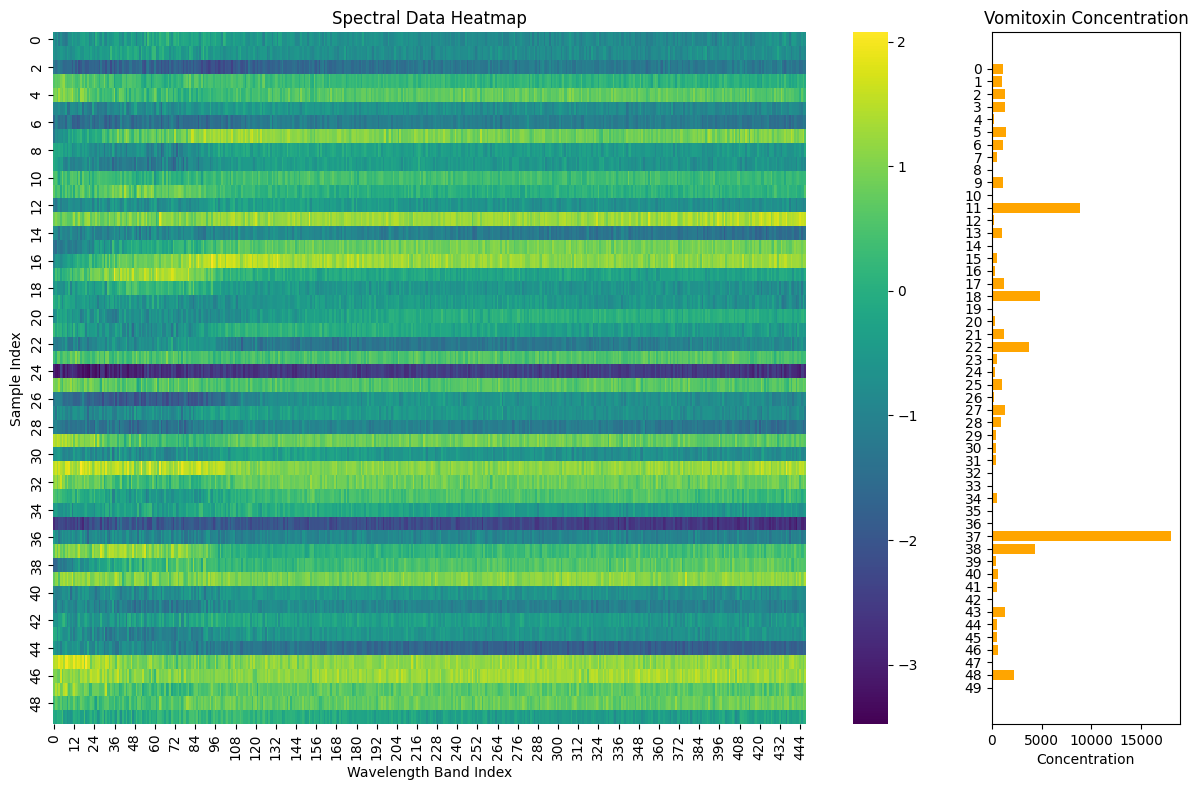

In [154]:
#Plotting Heatmap of the Spectral Data along with DON Concentration for a subset of data samples.
plotSpectralHeatMap(XS_df, y, 0, 50) #arguments are features dataframe, labels, subset start index, and subset end index

No clear correlation is seen between a few specific features and DON concentration values right away from the spectral heat map. So going ahead to see how the concentration values are distributed across samples in the given data.

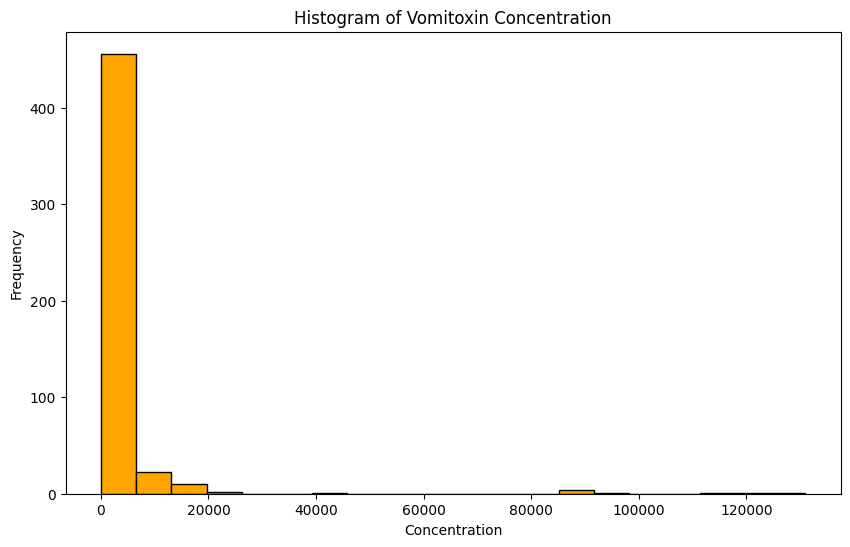

In [155]:
#Plotting histogram to see the distribution of DON(Vomitoxin) concentrations
plotHistogram(y)

Looks like the DON (Vomitoxin) concentration values in the dataset follow a long tailed distribution containing very few samples with a very high DON (Vomitoxin) Concentrations. The high concentration samples can also be outliers. Checking it ahead.

Performing dimensionality reduction using Principle Component Analysis to reduce the feature dimensions.

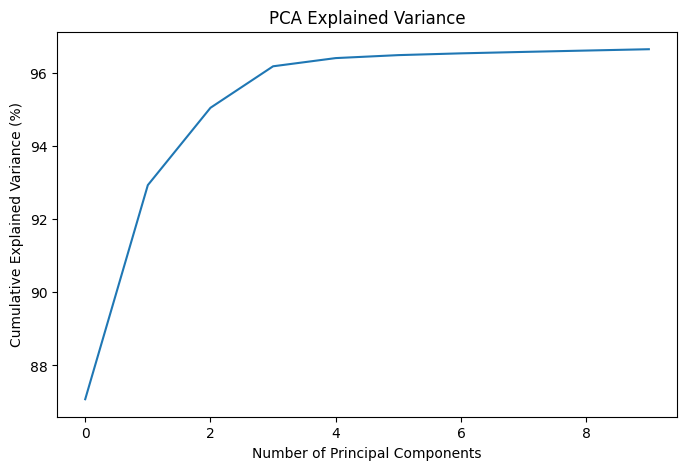

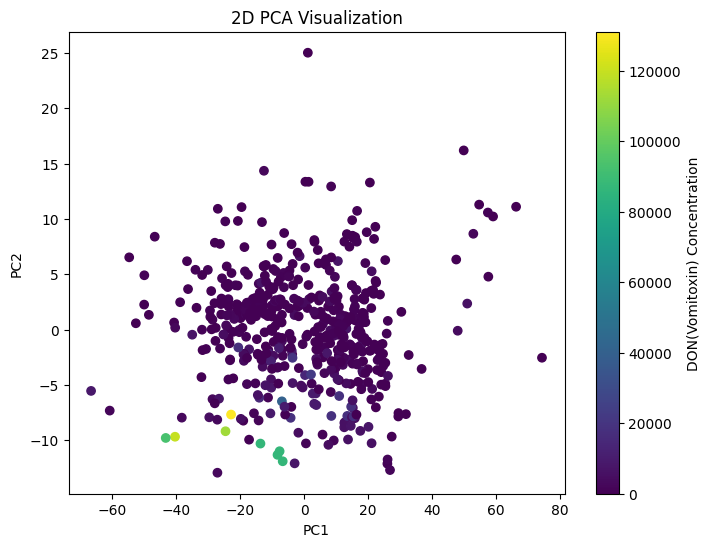

In [156]:
#Performing PCA on the features to reduce feature dimensions.
performPCA(XS_df, y, 10) #arguments are features dataframe, labels, and number of components to be considered

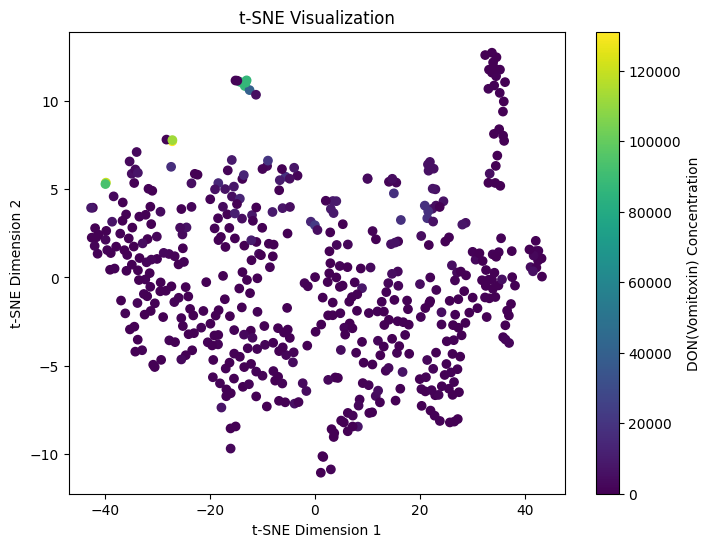

In [157]:
#Visualizing the data distribution with 2D t-SNE
plotTSNE(XS_df, y, 2)

There does not seem to be any proper clusters/separation/order among the samples with respect to the concentration values. We may have to choose a few best features that represent the concentrations well. Hence we compute correlation scores with the concentration values. Checking top absolute correlation scores may help in identifying the best features.

In [158]:
#count number of samples above 30000
count_above_30000 = (y > 30000).sum()
print(f"Number of samples with vomitoxin concentration above 30000: {count_above_30000}")

Number of samples with vomitoxin concentration above 30000: 9


In [159]:
#Removing those samples from the dataframe assuming them to be outliers
XS_df_filtered = XS_df[y <= 30000]
print(XS_df_filtered.info())
y_filtered = y[y<=30000]
print(y_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 0 to 499
Columns: 448 entries, 0 to 447
dtypes: float64(448)
memory usage: 1.7 MB
None
<class 'pandas.core.series.Series'>
Int64Index: 491 entries, 0 to 499
Series name: vomitoxin_ppb
Non-Null Count  Dtype  
--------------  -----  
491 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB
None


Text(0, 0.5, 'Frequency')

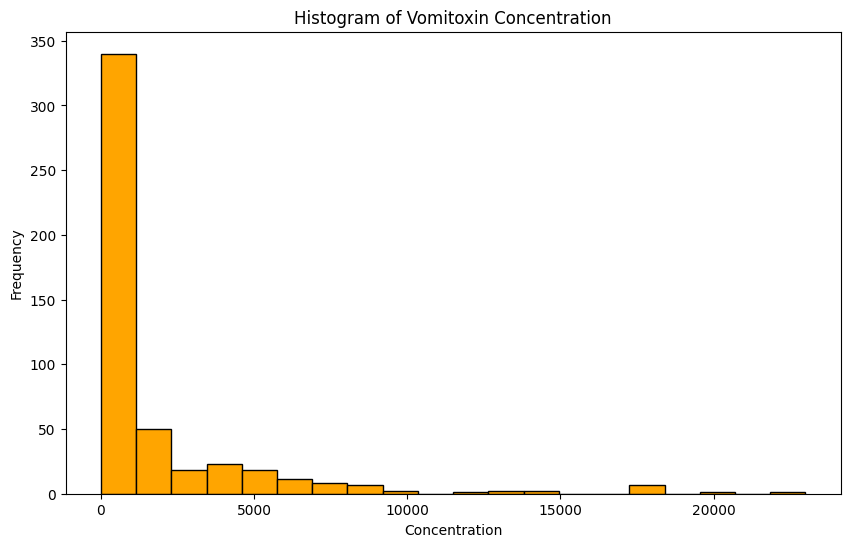

In [160]:
#Histogram visualization of vomitoxin concentration values
plt.figure(figsize=(10, 6))
plt.hist(y_filtered, bins=20, color='orange', edgecolor='black')
plt.title("Histogram of Vomitoxin Concentration")
plt.xlabel("Concentration")
plt.ylabel("Frequency")

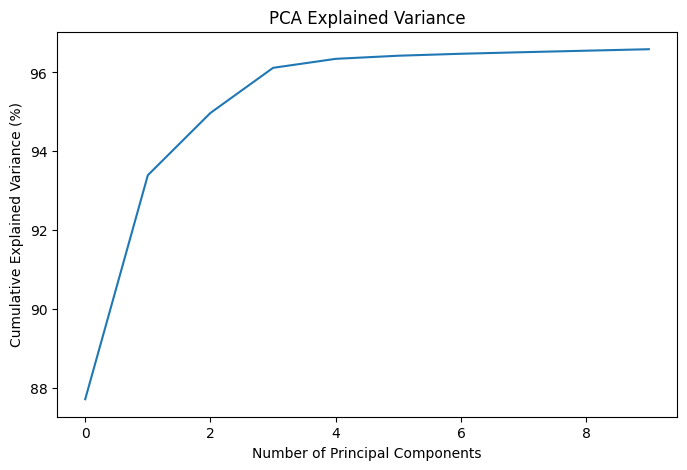

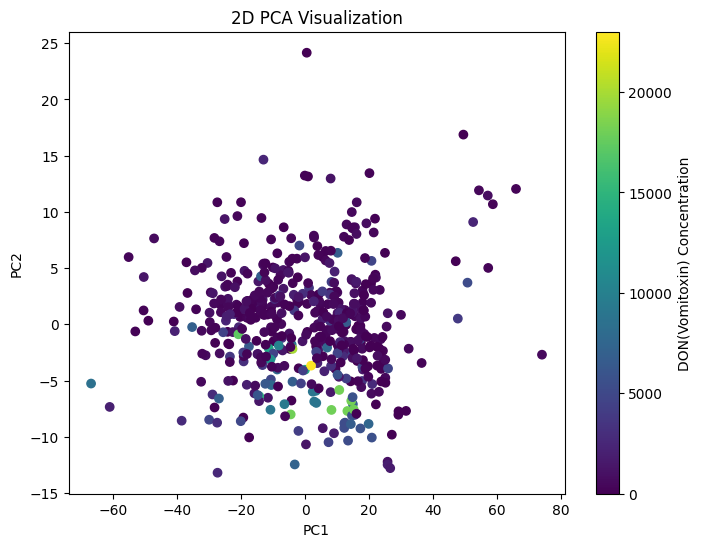

In [161]:
#Performing PCA on the updated dataset to reduce feature dimensions.
performPCA(XS_df_filtered, y_filtered, 10)

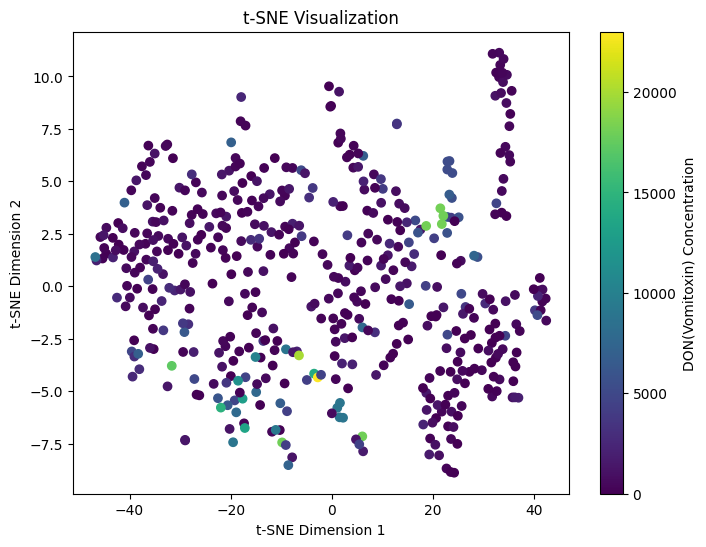

In [162]:
#Visualizing the updated/reduced data distribution with 2D t-SNE
plotTSNE(XS_df_filtered, y_filtered, 2)

There doesn't seem to be any improvement. Moreover, experiments showed that removing these samples doesn't improve the performance of the models. Infact, the performance actully reduced. So going ahead without removing them.

In [163]:
# Combine X and y for convenience
df = XS_df.copy()
df['label'] = y

# Calculate the absolute correlations of each feature with the label(DON Concentrations)
correlations = df.corr()['label'].drop('label')
correlations = correlations.abs()

# Sort the correlations by absolute value in descending order
top20 = correlations.sort_values(ascending=False).head(20)
top20_features = top20.index

# Display the original correlation values (preserving sign)
print("Top 20 features by absolute correlation with the label:")
for feature in top20_features:
    print(f"{feature}: {correlations[feature]:.4f}")

Top 20 features by absolute correlation with the label:
140: 0.3134
135: 0.3079
127: 0.3038
143: 0.3024
149: 0.3006
146: 0.3004
120: 0.2991
152: 0.2984
139: 0.2982
129: 0.2982
132: 0.2978
144: 0.2977
130: 0.2974
123: 0.2967
160: 0.2966
128: 0.2963
136: 0.2956
133: 0.2951
124: 0.2950
137: 0.2946


The top absolute correlation scores are very low and many features have similar correlation scores with the concentration values (labels). This indicates redundancy/multi collinearity. Only a subset of wavelength bands / features may be truly predictive. To identify a threshold to filter out features let's plot a line plot of ansolute values of correlation scores of all the features with the true labels.

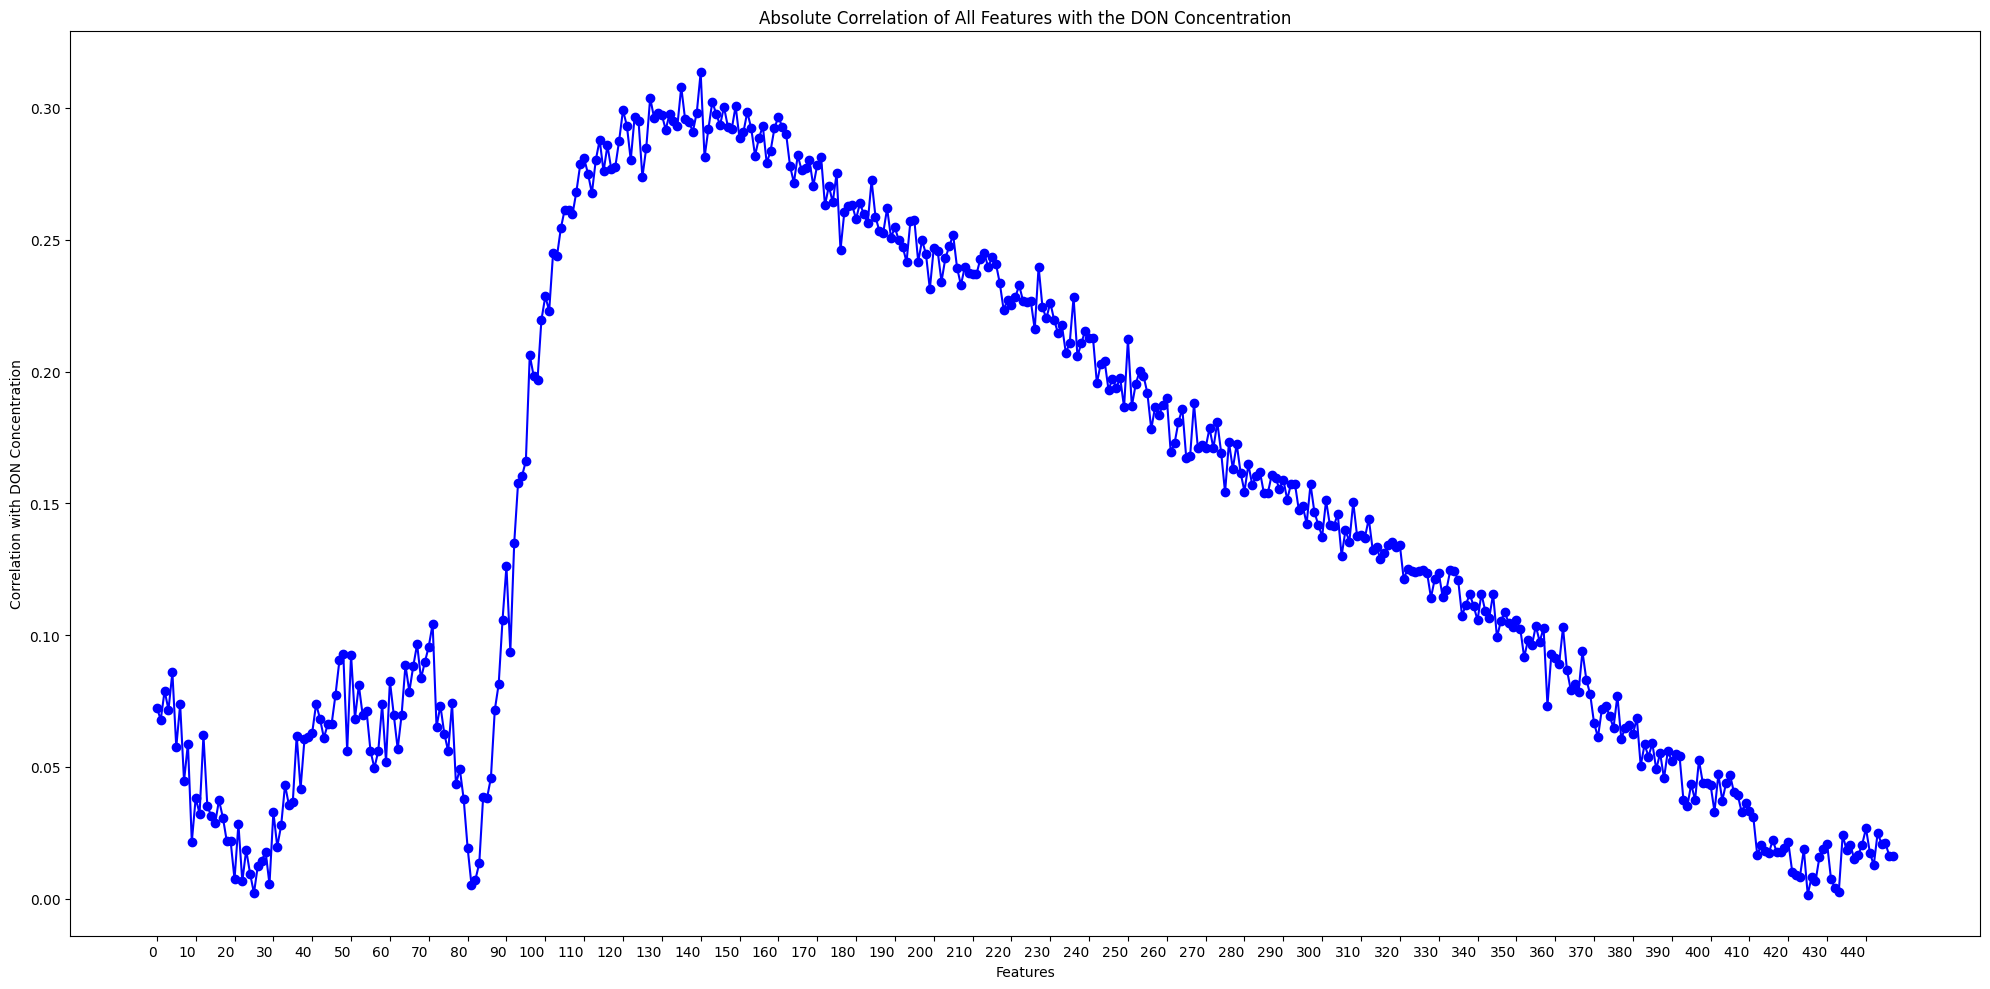

In [164]:
# Plot the correlation values for all features
plt.figure(figsize=(20, 10))
# correlations.plot(kind='bar', color='skyblue')
plt.plot(correlations.index, correlations.values, marker='o', linestyle='-', color='b')
plt.xlabel('Features')
plt.ylabel('Correlation with DON Concentration')
plt.title('Absolute Correlation of All Features with the DON Concentration')
# Set ticks at every 20 features to reduce clutter
step = 10
ticks = np.arange(0, len(correlations), step)
plt.xticks(ticks, correlations.index[ticks], rotation=0, ha='right')

plt.tight_layout()
plt.show()

Based on the above plot, 0.15 looks like a reasonable threshold to select a few useful features. Filtering the features accordingly.

In [165]:
# Identify features with correlation >= 0.1
selected_features = correlations[correlations >= 0.1].index.tolist()

# Save the list to a file for using it later while inference
with open("../streamlit_app/selected_features.pkl", "wb") as f:
    pickle.dump(selected_features, f)

# Filter the dataframe to include only the selected features
XS_df_filtered = df[selected_features]

print("Dataframe shape before filtering:", df.shape)
print("Dataframe shape after filtering:", XS_df_filtered.shape)

Dataframe shape before filtering: (500, 449)
Dataframe shape after filtering: (500, 265)


Performing PCA again on the new features and visualizing the 2D PCA (top 2 PCA components) and t-SNE to see if there is any improvement in the sample distributions with new representations.

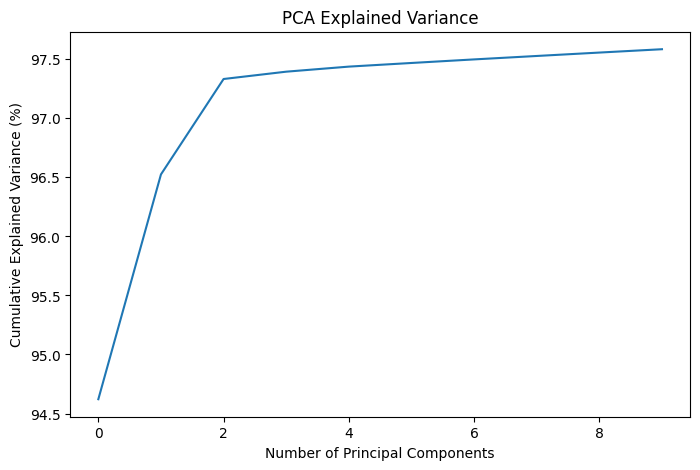

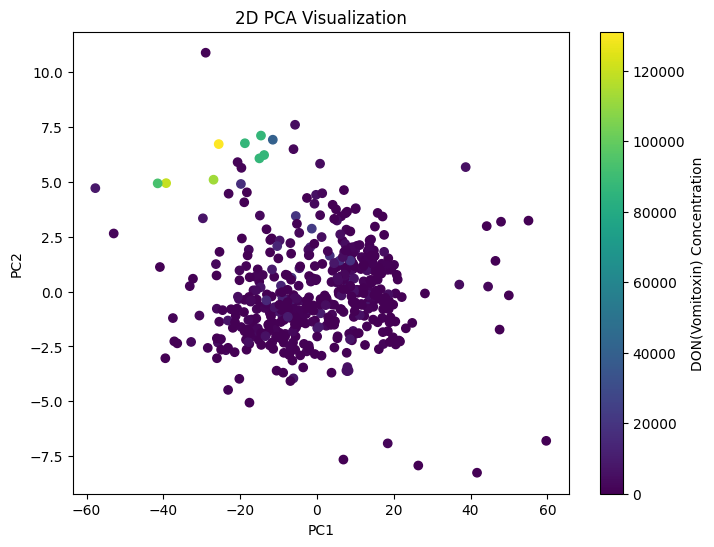

In [166]:
#Performing PCA on the updated features to reduce feature dimensions.
performPCA(XS_df_filtered, y, 10)

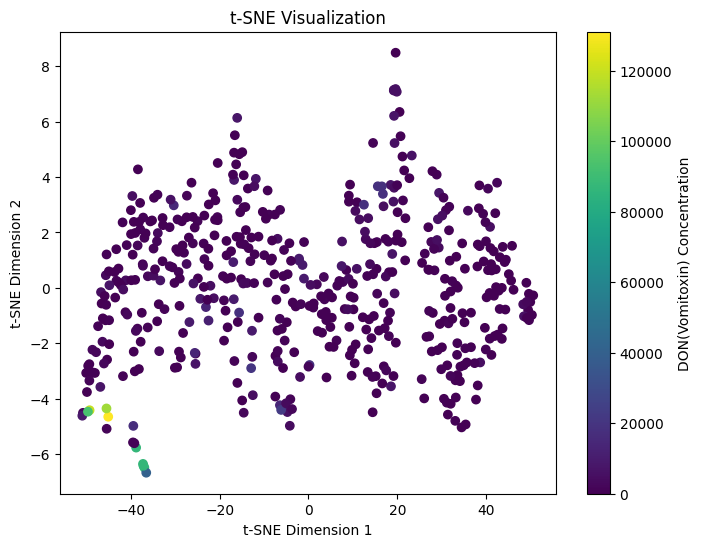

In [167]:
#Visualizing the updated/reduced data distribution with 2D t-SNE
plotTSNE(XS_df_filtered, y, 2)

Even now the samples does not seem to be nicely separated nor following certain pattern. So moving ahead to model selection and training with complete set of features. Firstly, we split the data into train and test splits.

In [168]:
selected_features = correlations[correlations >= 0].index.tolist() #All features.

In [169]:
#Randomly split the given dataset into train and test splits (80-20 splits)
X_train, X_test, y_train, y_test = train_test_split(XS_df, y, test_size=0.2, random_state=42)

We start by experimenting with **Random Forest Regression** model. Since Random Forest operates by constructing multiple decision trees, it can deal with many spectral features (wavelengths) without requiring explicit dimensionality reduction. Although we have filtered features to reduce multi-collinearity there may still be some extent of multicollinearity among the retained features. Random Forest is not significantly affected by those collinear (highly correlated) features. Random Forest also captures non-linear relationship between features and labels effectively.

In [170]:
#Train a Random Forest Regression model
RF_model = perform_RFReg_with_GridSearch(X_train, y_train)
# Save the model to a file
with open('../models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(RF_model, file)

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


Mean Absolute Error (MAE): 3967.272478075237
Root Mean Squared Error (RMSE): 12347.868192524587
R² Score: 0.4545553216804036


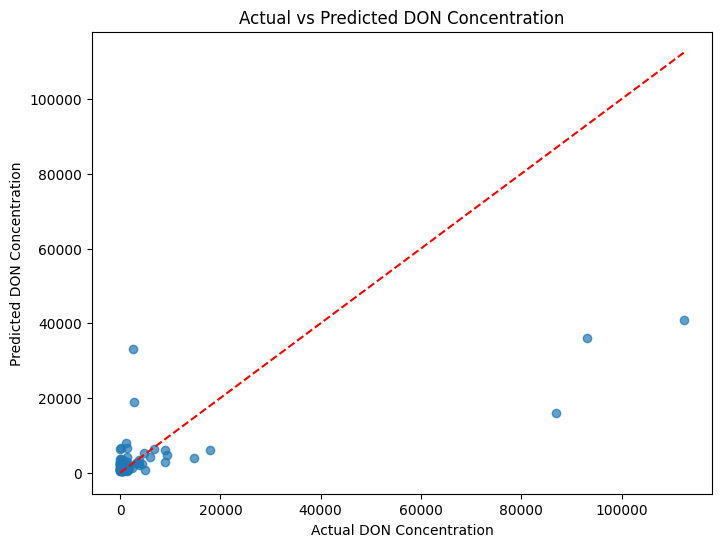

In [171]:
#Evaluate the trained Random Forest Regression model on the test set and plot a scatter plot of actual vs predicted concentrations.
plotScatterActualVsPreds(RF_model, X_test, y_test)

Random Forest usually needs extensive training with reasonably large dataset. But here we have a small dataset. So we may improve the results using different models.


---


Unlike **Random Forest** which builds independent trees, **XG Boost** builds trees sequentially by correcting errors of previous ones. Owing to its optimization, it is known to often outperform Random Forest in both speed and accuracy. So we try XG Boost Regression model.

In [172]:
#Train a XG Boost model with Grid search for choosing the best hyperparameters
xgb_model = perform_XGB_Reg_with_GridSearch(X_train, y_train)
# Save the model to a file
with open('../models/xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}


Mean Absolute Error (MAE): 4082.6815547466276
Root Mean Squared Error (RMSE): 13232.696693358736
R² Score: 0.37358311543424483


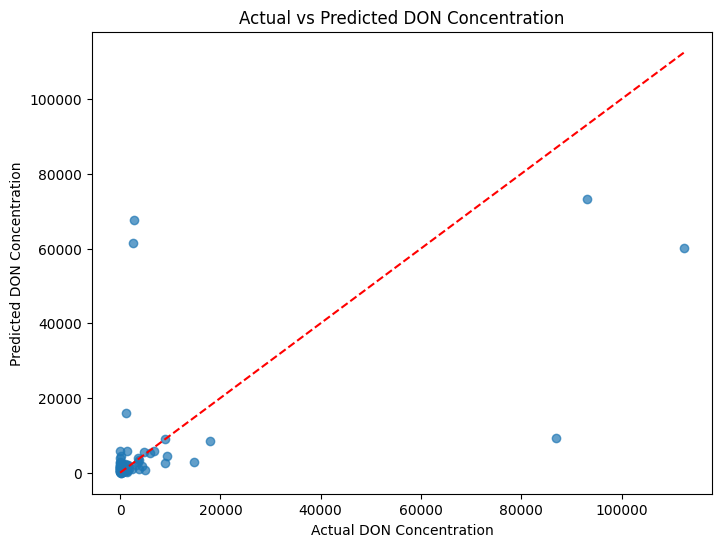

In [173]:
#Evaluate the trained XG Boost model on the test set and plot a scatter plot of actual vs predicted concentrations.
plotScatterActualVsPreds(xgb_model, X_test, y_test)

Unfortunately, there seems to be a drop in performance on our task as compared to Random Forest Regression. The dataset being small and the model
being more sensitive to hyperparameters can be the possible reasons. While sequentially building trees, correcting the errors in previous ones, XG Boost may fit on the noise present in the dataset too. This leads to overfitting on the training set and thus a worse performance on the test set.

---


Being designed for highly correlated features, **Partial Least Squares Regression** (PLS) explicitly finds latent variables that best explain both the spectral data and the target variable. When the number of samples is small relative to the number of features, PLS can still provide meaningful results, whereas tree-based models may struggle. Hence hoping to get better results we try Partial Least Squares Regression model on our dataset.

n_components=1, CV MAE=4436.9694
n_components=2, CV MAE=4786.1164
n_components=3, CV MAE=4383.4227
n_components=4, CV MAE=5059.0917
n_components=5, CV MAE=5631.4457
n_components=6, CV MAE=6419.1156
n_components=7, CV MAE=7072.8103
n_components=8, CV MAE=8006.1558
n_components=9, CV MAE=9004.0305
n_components=10, CV MAE=9870.4263
n_components=11, CV MAE=10750.3172
n_components=12, CV MAE=11537.8032
n_components=13, CV MAE=12225.8820
n_components=14, CV MAE=12792.6805
n_components=15, CV MAE=13272.0250
n_components=16, CV MAE=13699.7745
n_components=17, CV MAE=14064.1092
n_components=18, CV MAE=14336.7795
n_components=19, CV MAE=14552.4681
n_components=20, CV MAE=14771.1822
n_components=21, CV MAE=14943.6751
n_components=22, CV MAE=15067.5376
n_components=23, CV MAE=15166.1885
n_components=24, CV MAE=15241.9561

Best number of components: 3


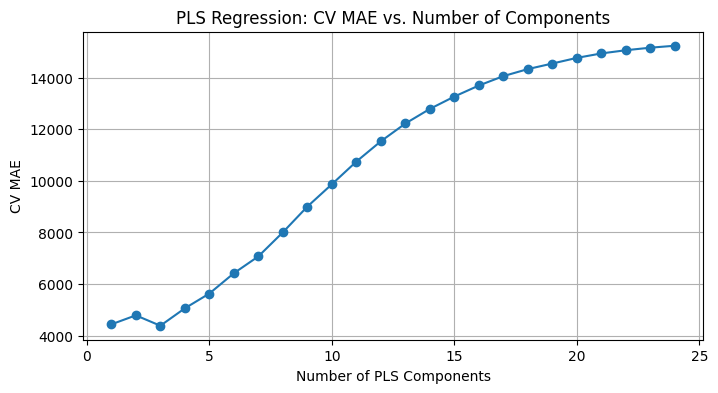

In [174]:
#Train a Partial Least Squares Regression model with Cross Validation
pls_model = perform_PLS_Reg(X_train, y_train)
# Save the model to a file
with open('../models/pls_model.pkl', 'wb') as file:
    pickle.dump(pls_model, file)

Mean Absolute Error (MAE): 4810.310171665522
Root Mean Squared Error (RMSE): 11915.849931409615
R² Score: 0.4920548837164971


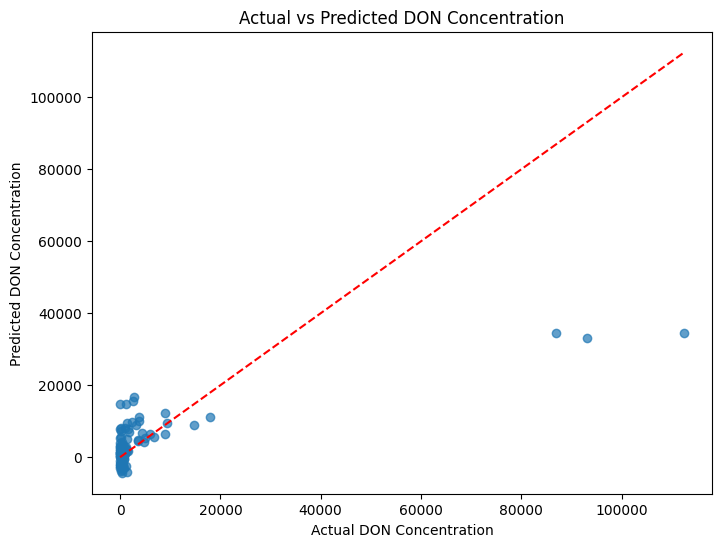

In [175]:
#Evaluate the trained Partial Least Squares Regression model on the test set and plot a scatter plot of actual vs predicted concentrations.
plotScatterActualVsPreds(pls_model, X_test, y_test)

Although, Partial Least Squares Regression model gives better predictions on the test split, its's not significanlty better than RF Regression.

Finally, trying out training a **Neural Network** with L1 regularization to perform this task. While the neural network can approximate complex non-linear functions, L1 regularisation enforces sparcity on weights thus selectively choosing the features. It also prevents overfitting on the training data.

Epoch 1/200 - Train Loss: 120944678.7000, Val Loss: 284784247.1031
Epoch 2/200 - Train Loss: 120868497.5250, Val Loss: 284357004.5641
Epoch 3/200 - Train Loss: 120435933.9250, Val Loss: 282320642.9469
Epoch 4/200 - Train Loss: 118986806.0375, Val Loss: 276976871.3000
Epoch 5/200 - Train Loss: 117110221.1500, Val Loss: 270950810.8750
Epoch 6/200 - Train Loss: 115572662.3000, Val Loss: 264549856.3000
Epoch 7/200 - Train Loss: 113744811.6625, Val Loss: 257550169.8500
Epoch 8/200 - Train Loss: 110964351.3750, Val Loss: 250153417.2000
Epoch 9/200 - Train Loss: 107646537.7625, Val Loss: 237906854.9500
Epoch 10/200 - Train Loss: 102717841.4875, Val Loss: 229608565.9250
Epoch 11/200 - Train Loss: 97084166.9625, Val Loss: 210482920.7000
Epoch 12/200 - Train Loss: 92739018.6125, Val Loss: 201886364.9500
Epoch 13/200 - Train Loss: 86179143.7969, Val Loss: 177366628.2500
Epoch 14/200 - Train Loss: 75846811.9469, Val Loss: 162378691.6125
Epoch 15/200 - Train Loss: 77789755.0375, Val Loss: 149485914

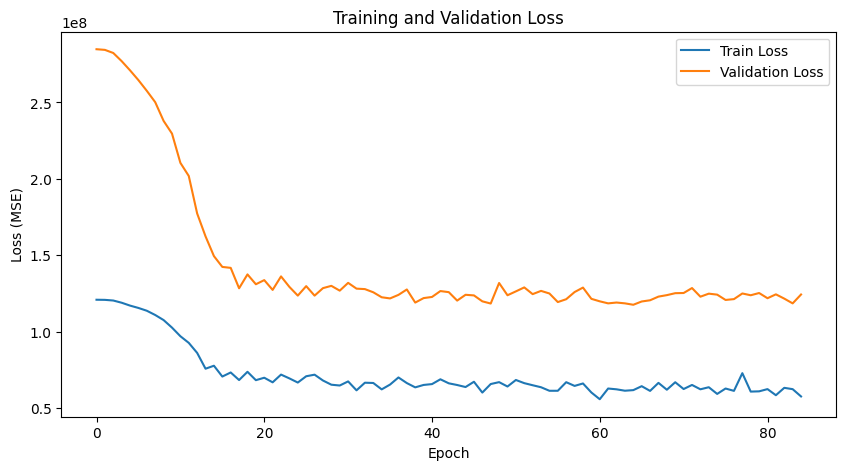

Test MAE: 3808.3708
Test RMSE: 11243.9951
Test R² Score: 0.5477


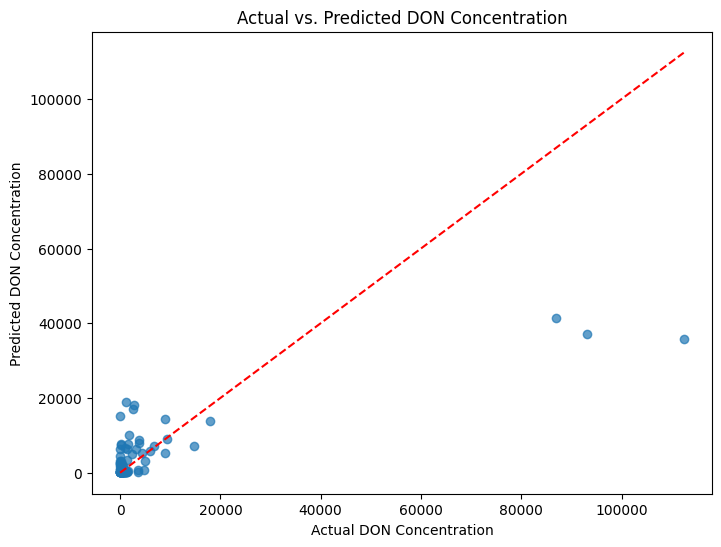

In [176]:
model_save_path = "../models/nn_model.pt"
perform_Reg_with_NN(X_train, y_train, X_test, y_test, input_dim = len(selected_features), save_path = model_save_path)

The overall best performance is obtained from the **Neural Network** model.